In [1]:
import pymysql
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from item_embedding import item_encode
from preprocess_user import make_user_fans_pipeline
from etl import load_user_info_features
from etl import load_fans_info_features

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score

from tensorflow.keras.layers import Input, Embedding, Dot, Add,Flatten,Dense,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow as tf

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def preprocess_goods():
    '''
        Get goods data
        Encode goods to vectors
        
        Parameters:
        
        Returns:
            encoded_items: (N_items, item_embedding_dimension)
            goods: goods dataframe
    '''
    conn = pymysql.connect(host = '127.0.0.1', 
                       user = 'root', 
                       password = 'root123', 
                       db = 'delidou')

    goods = pd.read_sql_query('''
        select g.* from base_goods g
        inner join(
            select distinct u.id as uid from base_user_info u
            inner join(
                select id from base_user_fans
            ) f on u.id = f.id
        ) uf on g.id = uf.uid
    ''', conn)
    
    encoded_items,goods = item_encode(goods)
    goods = goods.reset_index(drop = True)
    
    n_users = goods['id'].nunique()
    n_items = goods.link_id.nunique()
    n_pref = goods.shape[0]

    # print('Number of users: {}'.format(n_users))
    # print('Number of items: {}'.format(n_items))
    # print('Number of records: {}'.format(n_pref))
    
    return encoded_items, goods


def filter_goods_and_users(goods, user_n_item = 10, item_n_user = 10):
    '''
        Select top users and items
    '''
    
    item_count = goods.groupby('link_id')['id']\
        .agg(lambda x:len(set(x))).reset_index()\
        .sort_values(by = 'id',ascending = False)
    
    top_link_ids = item_count[item_count.id > item_n_user].link_id.values
    
    user_count = goods.groupby('id')['link_id']\
        .agg(lambda x:len(set(x))).reset_index()\
        .sort_values(by = 'link_id',ascending = False)
    
    top_user_ids = user_count[user_count.link_id > user_n_item].id.values
    
    goods = goods[(goods.id.isin(top_user_ids)) & (goods.link_id.isin(top_link_ids))]
    # goods = goods[(goods.id.isin(top_user_ids)) & (goods.link_id.isin(top_link_ids)) & (goods.id.isin(user_fans.id.values))]
    
    return goods,top_link_ids, top_user_ids



def load_user_features(n_regions = 30):
    
    '''Load user and fans data, process using predefined pipeline'''
    
    user = load_user_info_features()
    fans = load_fans_info_features()
    user_fans = user.merge(fans, on = 'id', how = 'inner')
    pipe = make_user_fans_pipeline(n_regions)
    user_features = pipe.fit_transform(user_fans)
    return user_features, user_fans



def userinfo_to_id(user_features, user_fans, user2id):
    result = []
    for user, f  in zip(user_fans.id.values, user_features):
        if user in user2id.keys():
            result.append([user2id[user],*f])

    user_features = pd.DataFrame(result)
    user_features.columns = ['user_id' if col == 0 else 'F_' + str(col) for col in user_features]
    user_features = user_features.iloc[:,1:]
    return user_features



def make_rating_table(goods):
    '''
        Make a 3 column rating table
    '''
    ratings = goods[['id','link_id']].copy()
    ratings['rating'] = 1
    ratings = ratings.rename(columns = {'id':'user_id','link_id':'item_id'})
    user2id = {user:i for i, user in enumerate(ratings.user_id.unique())}
    item2id = {item:i for i, item in enumerate(ratings.item_id.unique())}
    ratings['user_id'] = ratings['user_id'].replace(user2id)
    ratings['item_id'] = ratings['item_id'].replace(item2id)
    return ratings, user2id, item2id



def negative_sampling(ratings, n_negative = 50):
    '''
        Negative sampling
    '''
    all_items = set(ratings.item_id.unique())
    negative_samples = []
    for user_id in ratings.user_id.unique():
        user_items = set(ratings[ratings.user_id == user_id]['item_id'].tolist())
        space = list(all_items.difference(set(user_items)))
        neg_items = np.random.choice(space, size = n_negative)
        for neg_item in neg_items:
            negative_samples.append([user_id, neg_item,0])
    neg_ratings = pd.DataFrame(negative_samples,columns = ['user_id','item_id','rating'])
    dataset = pd.concat([ratings, neg_ratings])
    return dataset



def recommend_train_test_split(dataset, encoded_items, user_features, 
                               test_size = 0.1, shuffle = True):
    
    X_train, X_test, y_train,y_test =  train_test_split(dataset[['user_id','item_id']], 
                                                    dataset['rating'], 
                                                    test_size = 0.1, 
                                                    shuffle = True)

    item_encode_train = encoded_items[X_train.item_id.values]
    item_encode_test = encoded_items[X_test.item_id.values]
    
    user_feature_train = user_features.iloc[X_train.user_id.values,:]
    user_feature_test = user_features.iloc[X_test.user_id.values,:]
    
    
    print_info = '''
    ======================================
    Dataset Summary:
    ======================================
    X_train: {}
    X_test: {}
    item_encode_train: {}
    item_encode_test: {}
    user_feature_train: {}
    user_features_test: {}
    ======================================
    '''.format(X_train.shape, X_test.shape, 
               item_encode_train.shape, item_encode_test.shape, 
               user_feature_train.shape, user_feature_test.shape)
    
    print(print_info)
    
    return X_train, item_encode_train, user_feature_train,\
            X_test, item_encode_test, user_feature_test,y_train, y_test


def get_recommend_model(n_users, n_items, item_feature_dim, user_feature_dim, embed_hidden_dim = 10, reg = 0.):
    
    user_input = Input(1,)
    item_input = Input(1,)
    encoded_items_tensor = Input(item_feature_dim,)
    input_user_feature = Input(user_feature_dim,)

    user_embedding = Embedding(n_users,embed_hidden_dim, embeddings_regularizer=l2(reg))(user_input)
    item_embedding = Embedding(n_items,embed_hidden_dim, embeddings_regularizer=l2(reg))(item_input)

    user_bias = Embedding(n_users,1, embeddings_regularizer=l2(reg))(user_input)
    item_bias = Embedding(n_items,1, embeddings_regularizer=l2(reg))(item_input)

    rating_pred = Dot(axes = 2)([user_embedding, item_embedding])
    rating_pred = Add()([rating_pred, user_bias, item_bias])
    rating_pred = Flatten()(rating_pred)
    rating_pred = Concatenate()([rating_pred,encoded_items_tensor,input_user_feature])
    rating_pred = Dense(16, activation = 'relu')(rating_pred)
    rating_pred = Dense(1, activation = 'sigmoid')(rating_pred)

    model = Model([user_input, item_input,encoded_items_tensor,input_user_feature],rating_pred)
        
    model.compile(optimizer = Adam(lr = 0.001),loss = tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])
    return model
    
    
def evaluate_model(model, X_test, item_encode_test, user_feature_test,y_test):
    
    # predict
    preds = (model.predict(x = [X_test.user_id.values,
                                X_test.item_id.values,
                                item_encode_test, 
                                user_feature_test]) > 0.5).flatten()
    
    confuse = confusion_matrix(y_test, preds)
    fig, ax = plt.subplots(figsize = (6,4))
    sns.heatmap(confuse / confuse.sum(), annot = True)
    plt.title('Confusion Matrix')
    plt.show()
    
    auc = roc_auc_score(y_test, preds)
    acc = accuracy_score(y_test, preds)
    print('Accuracy Score: {}'.format(acc))
    print('Auc score: {}'.format(auc))

In [3]:
# items related pipelines
encoded_items, goods = preprocess_goods()
goods, top_link_ids, top_user_ids = filter_goods_and_users(goods)
ratings, user2id, item2id = make_rating_table(goods)
id2user = {v:k for k,v in user2id.items()}
id2item = {v:k for k,v in item2id.items()}

# user related pipelines
user_features, user_fans_df = load_user_features()
user_features = userinfo_to_id(user_features,user_fans_df,user2id)

# negative sampling ratings
dataset = negative_sampling(ratings)

# split and merge item and user data
X_train, item_encode_train, user_feature_train, \
    X_test, item_encode_test, user_feature_test,\
    y_train, y_test = recommend_train_test_split(dataset, 
                                                 encoded_items, 
                                                 user_features, 
                                                 test_size = 0.1,
                                                 shuffle = True)

# model structure based on data
model_params = dict(
    n_users = ratings.user_id.nunique(),
    n_items = ratings.item_id.nunique(),
    item_feature_dim = item_encode_train.shape[1],
    user_feature_dim = user_feature_train.shape[1],
    embed_hidden_dim = 10,
    reg = 0.
    )

# get the model
model = get_recommend_model(**model_params)

Building prefix dict from the default dictionary ...
I0822 18:28:52.416692 4486557120 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
I0822 18:28:52.419952 4486557120 __init__.py:131] Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
Loading model cost 0.622 seconds.
I0822 18:28:53.042079 4486557120 __init__.py:163] Loading model cost 0.622 seconds.
Prefix dict has been built succesfully.
I0822 18:28:53.043998 4486557120 __init__.py:164] Prefix dict has been built succesfully.



    Dataset Summary:
    X_train: (473708, 2)
    X_test: (52635, 2)
    item_encode_train: (473708, 128)
    item_encode_test: (52635, 128)
    user_feature_train: (473708, 127)
    user_features_test: (52635, 127)
    


In [4]:
EPOCHS = 20

history = model.fit(x = [X_train.user_id.values,X_train.item_id.values,item_encode_train,user_feature_train.values],y = y_train.values,
                   epochs = EPOCHS,
                   batch_size = 1024,
                   validation_data = (
                   [X_test.user_id.values,X_test.item_id.values,item_encode_test,user_feature_test], y_test.values)
                   )

Train on 473708 samples, validate on 52635 samples
Epoch 1/20
473708/473708 [==============================] - 2s 5us/sample - loss: 0.4591 - accuracy: 0.8188 - val_loss: 0.4180 - val_accuracy: 0.8300
Epoch 2/20
473708/473708 [==============================] - 2s 4us/sample - loss: 0.3769 - accuracy: 0.8496 - val_loss: 0.3669 - val_accuracy: 0.8590
Epoch 3/20
473708/473708 [==============================] - 2s 4us/sample - loss: 0.3041 - accuracy: 0.8835 - val_loss: 0.3268 - val_accuracy: 0.8771
Epoch 4/20
473708/473708 [==============================] - 2s 4us/sample - loss: 0.2448 - accuracy: 0.9061 - val_loss: 0.3105 - val_accuracy: 0.8815
Epoch 5/20
473708/473708 [==============================] - 2s 4us/sample - loss: 0.2010 - accuracy: 0.9220 - val_loss: 0.3077 - val_accuracy: 0.8868
Epoch 6/20
473708/473708 [==============================] - 2s 4us/sample - loss: 0.1691 - accuracy: 0.9336 - val_loss: 0.3138 - val_accuracy: 0.8867
Epoch 7/20
473708/473708 [=======================

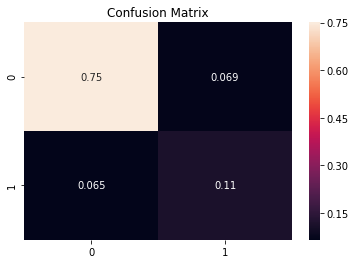

Accuracy Score: 0.8656787308824926
Auc score: 0.7767762136526798


In [5]:
evaluate_model(model, X_test, item_encode_test, user_feature_test,y_test)

In [6]:
def generate_recommends():
    all_items = set(ratings.item_id.unique())
    user = np.random.choice(X_test.user_id.values)
    user = np.repeat([user],len(all_items))  

    recos = np.argsort(model.predict([user, np.array(list(all_items)),encoded_items[list(all_items),],user_features.iloc[user].values]).flatten())[::-1][:30]
    goods[goods['id'] == id2user[user[0]]]

    print('Recommendation List:\n')
    for i, reco in enumerate(recos):
        print('No {}, Item: {}'.format(i+1,goods[goods.link_id == id2item[reco]]['name'].iloc[0]))

    print('\n\nKnown positive:\n')
    for i, good in enumerate(goods[goods['id'] == id2user[user[0]]]['name'].unique().tolist()):
        print('No {}, Item: {}'.format(i, good))

In [15]:
generate_recommends()

Recommendation List:

No 1, Item: 完美日记小酒管水光唇釉联名款新色唇彩唇蜜口红持久保湿镜面学生
No 2, Item: 半亩花田氨基酸洗面奶洁面乳泡沫深层清洁收毛孔控油面部男女学生
No 3, Item: 完美日记动物眼影盘锦鲤小狗小猫猫咪老虎斑虎小猪熊猫小鹿盘女
No 4, Item: 小奥汀眼线液笔 彩色防水不晕染持久棕色极细新手初学者胶笔奥丁
No 5, Item: TTOUCHME原创香膏固体香水持久留香男女士小众口袋古龙淡香随身香
No 6, Item: 半亩花田身体乳保湿滋润香体夏天清爽补水果酸去鸡皮女持久留香白
No 7, Item: 小奥汀雾感唇釉 丝绒雾面哑光唇彩唇蜜小众品牌女保湿滋润口红
No 8, Item: 完美日记口红小黑钻116持久保湿滋润显白春夏唇膏朱正廷代言学生
No 9, Item: 美康粉黛隔离霜学生平价妆前乳女打底保湿遮瑕素颜旗舰店官方正品
No 10, Item: 一叶子小V脸提拉面膜 面部修护提拉紧致淡化细纹补水保湿抗糖
No 11, Item: 半亩花田苦参除螨皂洗脸硫磺皂非海盐香皂面部男女深层清洁手工皂
No 12, Item: 卡婷清平乐联名长相思哑光口红持久保湿不易脱豆沙色唇膏小辣椒女
No 13, Item: 【24号发货】FORYON肤漾氨基酸补水保湿温和控油洁面慕斯正品。
No 14, Item: 小奥汀睫毛膏 浓密防水纤长卷翘持久不晕染不脱妆加长女彩色奥丁
No 15, Item: 半亩花田氨基酸控油除螨洗发水去屑止痒洗发露香味持久留香洗头膏
No 16, Item: MVE玻尿酸面膜女补水保湿 提亮肤色清洁收缩毛孔原液男女专用正品
No 17, Item: 薇娅推荐御泥坊氨基酸泥浆面膜深层清洁黑头毛孔控油涂抹式泥膜
No 18, Item: 一叶子熬夜精华液烟酰胺提亮肤色面部补水保湿原液水润改善暗沉女
No 19, Item: 完美日记哑光唇釉女学生雾面柔雾染唇液唇蜜唇彩口红持久显白
No 20, Item: 儒意马鞭草酮迷迭香马迷纯露去闭口粉刺毛孔收缩旗舰店官网正品米
No 21, Item: 稚优泉无惧幻想唇釉唇彩口红显白女学生平价丝绒雾面哑光不易掉色
No 22, Item: 安瓶精华爽肤水玻尿酸烟酰胺补水保湿喷雾收缩毛孔定妆化妆水男女
No 23, Item: 稚优

In [34]:
# conn = pymysql.connect(host = '127.0.0.1', 
#                        user = 'root', 
#                        password = 'root123', 
#                        db = 'delidou')

# goods = pd.read_sql_query('select * from base_goods', conn)

# encoded_items,goods = item_encode(goods)
# goods = goods.reset_index(drop = True)

# link_to_location = {link_id:location for location, link_id in goods['link_id'].reset_index().values}


# n_users = goods['id'].nunique()
# n_items = goods.link_id.nunique()
# n_pref = goods.shape[0]

# print('Number of users: {}'.format(n_users))
# print('Number of items: {}'.format(n_items))
# print('Number of records: {}'.format(n_pref))

# item_count = goods.groupby('link_id')['id'].agg(lambda x:len(set(x))).reset_index().sort_values(by = 'id',ascending = False)
# top_link_ids = item_count[item_count.id > 10].link_id.values
# user_count = goods.groupby('id')['link_id'].agg(lambda x:len(set(x))).reset_index().sort_values(by = 'link_id',ascending = False)
# top_user_ids = user_count[user_count.link_id > 10].id.values

# user = load_user_info_features()
# fans = load_fans_info_features()
# user_fans = user.merge(fans, on = 'id', how = 'inner')
# pipe = make_user_fans_pipeline(30)
# user_features = pipe.fit_transform(user_fans)

# goods = goods[(goods.id.isin(top_user_ids)) & (goods.link_id.isin(top_link_ids))]
# goods = goods[(goods.id.isin(top_user_ids)) & (goods.link_id.isin(top_link_ids)) & (goods.id.isin(user_fans.id.values))]

# ratings = goods[['id','link_id']].copy()
# ratings['rating'] = 1

# ratings = ratings.rename(columns = {'id':'user_id','link_id':'item_id'})
# user2id = {user:i for i, user in enumerate(ratings.user_id.unique())}
# item2id = {item:i for i, item in enumerate(ratings.item_id.unique())}
# ratings['user_id'] = ratings['user_id'].replace(user2id)
# ratings['item_id'] = ratings['item_id'].replace(item2id)

# result = []
# for user, f  in zip(user_fans.id.values, user_features):
#     if user in user2id.keys():
#         result.append([user2id[user],*f])
        
# user_features = pd.DataFrame(result)
# user_features.columns = ['user_id' if col == 0 else 'F_' + str(col) for col in user_features]
# user_features = user_features.iloc[:,1:]

# all_items = set(ratings.item_id.unique())
# n_negative = 50
# negative_samples = []
# for user_id in ratings.user_id.unique():
#     user_items = set(ratings[ratings.user_id == user_id]['item_id'].tolist())
#     space = list(all_items.difference(set(user_items)))
#     neg_items = np.random.choice(space, size = n_negative)
#     for neg_item in neg_items:
#         negative_samples.append([user_id, neg_item,0])
# neg_ratings = pd.DataFrame(negative_samples,columns = ['user_id','item_id','rating'])
# dataset = pd.concat([ratings, neg_ratings])

# itemid_to_location = {id_:link_to_location[link]for link,id_ in item2id.items()}
# X_train, X_test, y_train,y_test =  train_test_split(dataset[['user_id','item_id']], 
#                                                     dataset['rating'], 
#                                                     test_size = 0.1, 
#                                                     shuffle = True)

# item_encode_train = encoded_items[X_train.item_id.values]
# item_encode_test = encoded_items[X_test.item_id.values]
# user_feature_train = user_features.iloc[X_train.user_id.values,:]
# user_feature_test = user_features.iloc[X_test.user_id.values,:]



In [62]:
# reg = 0.

# user_input = Input(1,)
# item_input = Input(1,)
# encoded_items_tensor = Input(128,)
# input_user_feature = Input(127,)

# user_embedding = Embedding(N,K, embeddings_regularizer=l2(reg))(user_input)
# item_embedding = Embedding(M,K, embeddings_regularizer=l2(reg))(item_input)

# user_bias = Embedding(N,1, embeddings_regularizer=l2(reg))(user_input)
# item_bias = Embedding(M,1, embeddings_regularizer=l2(reg))(item_input)

# rating_pred = Dot(axes = 2)([user_embedding, item_embedding])
# rating_pred = Add()([rating_pred, user_bias, item_bias])
# rating_pred = Flatten()(rating_pred)
# rating_pred = Concatenate()([rating_pred,encoded_items_tensor,input_user_feature])
# rating_pred = Dense(16, activation = 'relu')(rating_pred)
# rating_pred = Dense(1, activation = 'sigmoid')(rating_pred)

# model = Model([user_input, item_input,encoded_items_tensor,input_user_feature],rating_pred)

# plot_model(model,show_shapes = True)

# model.compile(optimizer = Adam(lr = 0.001),loss = tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])

In [103]:
# preds = (model.predict(x = [X_test.user_id.values,X_test.item_id.values,item_encode_test, user_feature_test]) > 0.5).flatten()
# confusion_matrix(y_test, preds)